In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import deg2rad
from scipy.optimize import curve_fit
from scipy.ndimage import convolve1d
import seaborn as sns 
import HD_utils
from scipy.stats import wilcoxon, mannwhitneyu
import warnings
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

%load_ext autoreload
%autoreload 2


In [2]:
def load_data(ratname, file_path):
    # Load the .mat file
    with h5py.File(file_path, 'r') as f:
        # List all keys
        keys = list(f.keys())
        #print(f"Keys: {keys}")

        # Access the sdata structure
        sdata = f['sdata']

        # Check if 'light1' exists in sdata
        if 'light1' not in sdata:
            print(f"'light1' not found in {file_path}")
            return None

        # Accessing the light1 group and its datasets
        light1 = sdata['light1']
        ppox = np.array(light1['pox'])
        ppoy = np.array(light1['poy'])
        pot = np.array(light1['pot'])
        poh = np.array(light1['poh'])
        pov = np.array(light1['pov'])

        # Extract all cells containing the name 'R222'
        cell_names = [key for key in sdata.keys() if ratname in key]
        #print(f"Cell Names: {cell_names}")

        # Initialize dictionary to store data for all cells
        cells_data = {}

        # Iterate over each cell name and extract data
        for cell_name in cell_names:
            part_now = 'light1'  # Assuming 'light1' is the part_now equivalent

            pspx = np.array(sdata[cell_name][part_now]['spx'])
            pspy = np.array(sdata[cell_name][part_now]['spy'])
            pspt = np.array(sdata[cell_name][part_now]['spt'])
            pspv = np.array(sdata[cell_name][part_now]['spv'])
            psph = np.array(sdata[cell_name][part_now]['sph'])
            pspm = np.array(sdata[cell_name][part_now]['spm'])
            pval = np.array(sdata[cell_name][part_now]['pval'])
            spike_phase = np.array(sdata[cell_name][part_now]['spike_phase'])
            autocorrelogram = np.array(sdata[cell_name][part_now]['theta_train_long2'])
            hd_mean = np.array(sdata[cell_name][part_now]['hd_mean'])
            hd_std = np.array(sdata[cell_name][part_now]['hd_stdev'])
            tune_width = np.array(sdata[cell_name][part_now]['tuning_width'])

            # Extract and decode cell_type
            cell_type_array = np.array(sdata[cell_name][part_now]['thetacell_type'])
            cell_type = ''.join([chr(ascii_val[0]) for ascii_val in cell_type_array])

            # Store the data for this cell
            cells_data[cell_name] = {
                'pspx': pspx,
                'pspy': pspy,
                'pspt': pspt,
                'pspv': pspv,
                'psph': psph,
                'pspm': pspm,
                'pval': pval,
                'spike_phase': spike_phase,
                'autocorrelogram': autocorrelogram,
                'hd_mean': hd_mean,
                'hd_std': hd_std,
                'tune_width': tune_width,
                'cell_type': cell_type
            }

        # Create a dictionary to store all the data
        data_dict = {
            'ppox': ppox,
            'ppoy': ppoy,
            'pot': pot,
            'poh': poh,
            'pov': pov,
            'cell_names': cell_names,
            'cells_data': cells_data
        }

        return data_dict



In [3]:
def sinmodel(t, a, b, c, omega, t1, t2):
    return (a * (np.sin(2*np.pi*omega * t + np.pi/2) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2) 

def calculate_intrinsic_frequency(autocorrelogram):
    
    # Fit the model to the autocorrelogram data
    initial_guess = [1, 1, 0.1, 9, 1.0, 0.01]  # Initial guesses for a, b, c, omega, t1, t2
    bounds = ([0, 0, 0, 6, 0, 0], [100, 100, 0.8, 12, 8, 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    #normalze autocorr to 0-1
    lags = autocorrelogram[1, :] / 1000.  # Convert lags to seconds

    params, _ = curve_fit(sinmodel, lags, autocorr, p0=initial_guess, bounds=bounds)
    # Extract the intrinsic frequency (omega)
    intrinsic_frequency = params[3]
    print(f"Intrinsic Theta Frequency: {intrinsic_frequency:.2f} Hz")
    
    return intrinsic_frequency, params

def plot_head_direction_tuning(ax, ppoh, psph, config, pos_tb=0.02):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """

    # Convert angles to radians
    ppoh_rad = deg2rad(ppoh)
    psph_rad = deg2rad(psph)

    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(ppoh_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))
    hd2, _ = np.histogram(psph_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time

    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.max(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(0, 2 * np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)
    
    #calculate the preferred direction which corresponds to the peak of the tuning curve
    hd_peakfr = theta[np.argmax(hd3_normalized)]
    #add a line to indicate the preferred direction
    ax.plot([hd_peakfr, hd_peakfr], [0, 1], color='red', linestyle='--', linewidth=1)
    
    #instead, calculate the preferred direction using the circular mean
    hd_peakfr2 = np.angle(np.sum(np.exp(1j * psph_rad))) % (2 * np.pi)
    #add a line to indicate the preferred direction
    ax.plot([hd_peakfr2, hd_peakfr2], [0, 1], color='blue', linestyle='--', linewidth=1)
    

    #keep 0 90 180 270 as the xticks
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0°', '90°', '180°', '270°'])
    
    #remove yticks
    ax.set_yticks([])
    
    #ax.set_title(cell_name + '\n'+str(np.round(hd_mean,1))+'('+str(np.round(hd_std,1))+')' +'\nRayleigh_p=' + str(np.round(pval, 4)), fontsize=10)
    
    #ax.set_title(f"{cell_name}\nAngle:{hd_mean:.0f} ({hd_std:.0f})\nTuning width:{tune_width:.0f}\nRayleigh_p={pval:.4f}", fontsize=10)
    # ax.legend()
    #set x and y tick as 8 pt
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    return ax, hd_peakfr, hd_peakfr2


def get_adaptation(ppoh, pot, pspt, hd_peakfr, degreerange=6, timelength=0.33, timecut=0.16, rotType='still'):
    """
    Calculate adaptation based on periods when head direction (ppoh) is within the preferred range.

    Parameters:
        ppoh (numpy array): Rat head direction (in degrees).
        pot (numpy array): Timestamps for ppoh.
        psph: Head direction when a spike occurs.
        pspt: Accurate time when a spike occurs.
        hd_peakfr (float): Preferred direction (in radians).
        degreerange (int): Range around the preferred direction to consider (in degrees).

    Returns:
        list: A list of tuples where each tuple contains the start time, end time of a continuous period, 
              and the spike times within that period.
    """
    #ppoh to N dim not 1*N dim
    ppoh = ppoh.flatten()
    
    # Convert preferred direction from radians to degrees
    preferred_direction = np.rad2deg(hd_peakfr)

    # Calculate the wrapped difference between ppoh and preferred_direction
    diff = (ppoh - preferred_direction + 180) % 360 - 180

    # Assign True if the wrapped difference is within the degreerange, else False
    in_range = np.abs(diff) <= degreerange

    # Find the start and end indices of continuous periods using np.diff and np.where
    changes = np.diff(in_range.astype(int))
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0]

    # Handle cases where the first or last period is continuous
    if in_range[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if in_range[-1]:
        end_indices = np.append(end_indices, len(in_range) - 1)

    # Extract spike times within each continuous period
    
    inst_fr = []
    durations = []
    
    count = 0
    for start, end in zip(start_indices, end_indices):
        start_time = pot[start]
        end_time = pot[end]

        if rotType == 'still':
            if end_time - start_time < timelength:
                continue
        elif rotType == 'rot':
            if end_time - start_time < timelength or end_time - start_time > 2:
                continue
            timecut = (end_time - start_time) / 2
        
        count += 1 

        #count the number of spikes between start_time and start_time + timelength/2
        spikes_in_period_firsthalf = pspt[(pspt >= start_time) & (pspt <= start_time+timecut)]
        
        #count the number of spikes between start_time + timelength/2 and start_time + timelength
        spikes_in_period_secondhalf = pspt[(pspt > end_time - timecut) & (pspt <= end_time)]
        
        # Ensure at least two spikes exist in each window
        if len(spikes_in_period_firsthalf) < 1 or len(spikes_in_period_secondhalf) < 1:
            continue
        
        # Ensure ISI calculation doesn't include zero values
        # don't know why, but happen few times....
        if 0 in np.diff(spikes_in_period_firsthalf) or 0 in np.diff(spikes_in_period_secondhalf):
            continue
        
        #calculate the mean firing rate
        initial_instfr = len(spikes_in_period_firsthalf) / timecut
        final_instfr = len(spikes_in_period_secondhalf) / timecut
        # initial_instfr = np.mean(1./np.diff(spikes_in_period_firsthalf))
        # final_instfr = np.mean(1./np.diff(spikes_in_period_secondhalf))        
        
        inst_fr.append((initial_instfr, final_instfr))
        durations.append(end_time - start_time)
    
    return inst_fr, durations

def get_adaptation_halfwindowsize(ppoh, pot, psph, pspt, hd_peakfr, degreerange=6, timelength=0.33, timecut=0.16):
    """
    Calculate adaptation based on periods when head direction (ppoh) is within the preferred range.

    Parameters:
        ppoh (numpy array): Rat head direction (in degrees).
        pot (numpy array): Timestamps for ppoh.
        psph: Head direction when a spike occurs.
        pspt: Accurate time when a spike occurs.
        hd_peakfr (float): Preferred direction (in radians).
        degreerange (int): Range around the preferred direction to consider (in degrees).

    Returns:
        list: A list of tuples where each tuple contains the start time, end time of a continuous period, 
              and the spike times within that period.
    """
    #ppoh to N dim not 1*N dim
    ppoh = ppoh.flatten()
    
    # Convert preferred direction from radians to degrees
    preferred_direction = np.rad2deg(hd_peakfr)

    # Calculate the wrapped difference between ppoh and preferred_direction
    diff = (ppoh - preferred_direction + 180) % 360 - 180

    # Assign True if the wrapped difference is within the degreerange, else False
    in_range = np.abs(diff) <= degreerange

    # Find the start and end indices of continuous periods using np.diff and np.where
    changes = np.diff(in_range.astype(int))
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0]

    # Handle cases where the first or last period is continuous
    if in_range[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if in_range[-1]:
        end_indices = np.append(end_indices, len(in_range) - 1)

    # Extract spike times within each continuous period
    results = []
    spikeratios = []
    
    inst_fr = []
    durations = []
    
    count = 0
    for start, end in zip(start_indices, end_indices):
        start_time = pot[start]
        end_time = pot[end]
        
        #if end_time - start_time < 0.3: do not consider this period
        # if end_time - start_time < timelength:
        if end_time - start_time < 0.01 or end_time - start_time > 2:
            continue
        count += 1 

        # Find spike times within the period of start_time and start_time + timelength
        spikes_in_period = pspt[(pspt >= start_time) & (pspt <= start_time + timelength)]
        
        #get head direction when spikes occur for later sanity check
        # index = np.where((pspt >= start_time) & (pspt <= start_time + timelength))[0]
        # head_direction_at_spikes = psph[index]
        timecut = (end_time - start_time) / 2
        
        #count the number of spikes between start_time and start_time + timelength/2
        spikes_in_period_firsthalf = pspt[(pspt >= start_time) & (pspt <= start_time+timecut)]
        
        #count the number of spikes between start_time + timelength/2 and start_time + timelength
        spikes_in_period_secondhalf = pspt[(pspt > end_time - timecut) & (pspt <= end_time)]
        
        if len(spikes_in_period_firsthalf) < 2 or len(spikes_in_period_secondhalf) <2:
            continue
        else:
            #calculate the instantaneous firing rate
            initial_instfr = np.mean(1./np.diff(spikes_in_period_firsthalf))
            final_instfr = np.mean(1./np.diff(spikes_in_period_secondhalf))
            #calculate the firing rate by sum of spikes / time
            # initial_instfr = len(spikes_in_period_firsthalf) / (spikes_in_period_firsthalf[-1] - spikes_in_period_firsthalf[0])
            # final_instfr = len(spikes_in_period_secondhalf) / (spikes_in_period_secondhalf[-1] - spikes_in_period_secondhalf[0])
            
            inst_fr.append((initial_instfr, final_instfr))
            durations.append(end_time - start_time)
            
            # spikeratio = (len(spikes_in_period_firsthalf) - len(spikes_in_period_secondhalf)) / (len(spikes_in_period_secondhalf) + len(spikes_in_period_firsthalf))
        
        # results.append((preferred_direction, start_time, end_time, head_direction_at_spikes, spikes_in_period, spikeratio))
        # print(start_time, end_time, len(spikes_in_period))
        
        # spikeratios.append(spikeratio)
      
    return inst_fr, durations

In [4]:
def extract_initial_final_instfr(instfr, takewithincellmean=False):
    initial_instfr = []
    final_instfr = []
    if takewithincellmean is False:
        for i in range(len(instfr)):
            if len(instfr[i]) == 0:
                continue
            else:
                for j in range(len(instfr[i])):
                    initial_instfr.append(instfr[i][j][0])
                    final_instfr.append(instfr[i][j][1])
    else:
        for i in range(len(instfr)):
            if len(instfr[i]) == 0:
                continue
            else:
                initial_instfr.append(np.mean([instfr[i][j][0] for j in range(len(instfr[i]))]))
                final_instfr.append(np.mean([instfr[i][j][1] for j in range(len(instfr[i]))]))
    return initial_instfr, final_instfr

def extract_dur(dur):
    #dur is a list of list
    #change to a list
    durations = []
    for i in range(len(dur)):
        if len(dur[i]) == 0:
            continue
        else:
            for j in range(len(dur[i])):
                durations.append(dur[i][j])
    return durations

def get_adaptation_for_all(degreerange, timelength, timecut, return_mean=True, rotType='still'):

    #do not show warnings
    warnings.filterwarnings("ignore")

    base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'

    # Configuration
    config = {
        'hd_bins': 60,
        'hd_boxcar': 3,
        'speed_threshold': 0.5,
        'duration_threshold': 0.5,
        'speed_smooth_sigma': 40,  #0.8,0.8,40 gives 43% pp cells
        'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
        'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
        'IFR_window':0.2
    }

    classicHD_instfr = []
    theta_instfr = []
    theta_nonskip_instfr = []
    theta_skip_instfr = []

    classicHD_dur = []
    theta_dur = []
    theta_nonskip_dur = []
    theta_skip_dur = []

    total_hd_cells = 0

    matnames = {}

    # Iterate through each subfolder in the base directory
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        if os.path.isdir(subdir_path):
            # Iterate through each .mat file in the subfolder
            for file in os.listdir(subdir_path):
                if file.endswith('_sdata.mat'):
                    file_path = os.path.join(subdir_path, file)
                    #print(f"Processing {file_path}")
                    ratname = file.split('_')[0]
                    data_dict = HD_utils.load_data(ratname, file_path)
                    
                    if data_dict is not None:
                        ppoh = data_dict['poh']
                        pot = data_dict['pot'].flatten()
                        
                        ppox = data_dict['ppox'].flatten()
                        ppoy = data_dict['ppoy'].flatten()
                        global_freq = data_dict['global_freq'][0][0]
                        
                        #interpolte pot 
                        sampling_interval = np.diff(pot).mean()
                        new_interval = sampling_interval / config['interpolation_factor']
                        pot_interp = np.arange(0, pot[-1], new_interval)
                        
                        for cell_name, cell_data in data_dict['cells_data'].items():
                            psph = cell_data['psph'].flatten()
                            pspt = cell_data['pspt'].flatten()
                            spike_phase = cell_data['spike_phase'].flatten()
                            hd_pval = cell_data['pval'][0][0]
                            hd_mean = cell_data['hd_mean'][0][0]
                            hd_std = cell_data['hd_std'][0][0]
                            tune_width = cell_data['tune_width'][0][0]
                            autocorrelogram = cell_data['autocorrelogram']
                            intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                            hd_rayleigh = cell_data['hd_rayleigh'][0][0]
                            hd_rayleigh_shuffle_99 = cell_data['hd_rayleigh_shuffle_99'][0][0]
                            peak_fr = cell_data['peak_fr'][0][0]
                            intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                            cell_type = cell_data['cell_type']
                            
                            #store matname for each cell
                            matnames[cell_name] = [ratname, file_path]
                            
                            #if hd_pval < 0.05: #select only head direction tuned cells
                            if hd_rayleigh > hd_rayleigh_shuffle_99 and peak_fr > 1: #select only head direction tuned cells with rayleigh vector > 99% shuffle and the peak firing rate in the directional field is greater than 1 Hz
                                try:
                                    fig = plt.figure(figsize=(4.2, 1.5), dpi=300)
                                    gs=fig.add_gridspec(1, 1)
                                    
                                    ax0 = fig.add_subplot(gs[0], projection='polar')
                                    #head direction tuning curve, hd_peakfr is the preferred direction
                                    #hd_peakfr2 is the preferred direction calculated using circular mean
                                    ax0, hd_peakfr, hd_peakfr2 = plot_head_direction_tuning(ax0, ppoh, psph, config)
                                    
                                    #caulcate firing rate adaptation get_adaptation_halfwindowsize
                                    inst_fr, dur = get_adaptation(ppoh, pot, pspt, hd_peakfr, degreerange=degreerange, timelength=timelength, timecut=timecut, rotType=rotType)
                                    # inst_fr, dur = get_adaptation_halfwindowsize(ppoh, pot, psph, pspt, hd_peakfr, degreerange=degreerange, timelength=timelength, timecut=timecut)
                                
                                    #save fig according to cell type in different folders
                                    if cell_type == ' Strong ThetaxHD ' or cell_type == ' Strong ThetaxHD  & skip': #This is a theta modulated HD cell
                                        #if pval<0.05 and clr<0: 
                                        #if True:
                                        # if pval<0.05:
                                        total_hd_cells += 1
                                        if True:
                                            theta_instfr.append(inst_fr)
                                            theta_dur.append(dur)
                                            
                                            if cell_type == ' Strong ThetaxHD  & skip': #this is a theta skipping cell
                                                theta_skip_instfr.append(inst_fr)
                                                theta_skip_dur.append(dur)
                                            elif cell_type == ' Strong ThetaxHD ': #this is a theta modulated non-skipping cell
                                                theta_nonskip_instfr.append(inst_fr)
                                                theta_nonskip_dur.append(dur)

                                    elif cell_type == ' HDC ':
                                        classicHD_instfr.append(inst_fr)
                                        classicHD_dur.append(dur)
                                        total_hd_cells += 1
                                        
                                    plt.close(fig)
                                    
                                except Exception as e:
                                    plt.close(fig)
                                    print(f"Error processing {cell_name}: {e}")
                            
    print(f"Total number of HD cells processed: {total_hd_cells}")

    #calculate the initial and final firing rate for each cell

    classicHD_initial_instfr, classicHD_final_instfr = extract_initial_final_instfr(classicHD_instfr, takewithincellmean=True)
    theta_initial_instfr, theta_final_instfr = extract_initial_final_instfr(theta_instfr, takewithincellmean=True)
    theta_nonskip_initial_instfr, theta_nonskip_final_instfr = extract_initial_final_instfr(theta_nonskip_instfr, takewithincellmean=True)
    theta_skip_initial_instfr, theta_skip_final_instfr = extract_initial_final_instfr(theta_skip_instfr, takewithincellmean=True)

    print(np.nanmean(classicHD_initial_instfr), np.nanmean(classicHD_final_instfr), len(classicHD_instfr), len(classicHD_initial_instfr), len(classicHD_initial_instfr)/len(classicHD_instfr))
    print(np.nanmean(theta_initial_instfr), np.nanmean(theta_final_instfr), len(theta_instfr), len(theta_initial_instfr), len(theta_initial_instfr)/len(theta_instfr))
    print(np.nanmean(theta_nonskip_initial_instfr), np.nanmean(theta_nonskip_final_instfr), len(theta_nonskip_instfr), len(theta_nonskip_initial_instfr), len(theta_nonskip_initial_instfr)/len(theta_nonskip_instfr))
    print(np.nanmean(theta_skip_initial_instfr), np.nanmean(theta_skip_final_instfr), len(theta_skip_instfr), len(theta_skip_initial_instfr), len(theta_skip_initial_instfr)/len(theta_skip_instfr))
 
    classicHD_dur = extract_dur(classicHD_dur)
    theta_dur = extract_dur(theta_dur)
    theta_nonskip_dur = extract_dur(theta_nonskip_dur)
    theta_skip_dur = extract_dur(theta_skip_dur)
    print('dur_mean:', np.nanmean(classicHD_dur), np.nanmean(theta_dur), np.nanmean(theta_nonskip_dur), np.nanmean(theta_skip_dur)) 
    print('dur_std:',np.nanstd(classicHD_dur), np.nanstd(theta_dur), np.nanstd(theta_nonskip_dur), np.nanstd(theta_skip_dur))
    print('dur_sem:', np.nanstd(classicHD_dur)/np.sqrt(len(classicHD_dur)), np.nanstd(theta_dur)/np.sqrt(len(theta_dur)), np.nanstd(theta_nonskip_dur)/np.sqrt(len(theta_nonskip_dur)), np.nanstd(theta_skip_dur)/np.sqrt(len(theta_skip_dur)))
    
    if return_mean == True:
        return {'classicHD_initial_instfr': np.nanmean(classicHD_initial_instfr), 
                'classicHD_final_instfr': np.nanmean(classicHD_final_instfr), 
                'PPHD_initial_instfr': np.nanmean(theta_initial_instfr), 
                'PPHD_final_instfr': np.nanmean(theta_final_instfr)}
    else:
        return {'classicHD_initial_instfr': classicHD_initial_instfr, 
                'classicHD_final_instfr': classicHD_final_instfr, 
                'PPHD_initial_instfr': theta_initial_instfr, 
                'PPHD_final_instfr': theta_final_instfr}

# Run with one parameter setting

In [5]:
rotType = 'still'
if rotType == 'still':
    degreerange = 15
    timecut = 0.15
    timelength = 1.5
elif rotType == 'rot':
    degreerange = 15
    timecut = None
    timelength = 0.01  
else:
    raise ValueError('rotType should be still or rot')


# degreerange = 15 #Taube & Muller 1998
# timecut = 0.15 #Taube & Muller 1998
# timelength = 2*timecut
# print(degreerange, timelength, timecut)

results_muller = get_adaptation_for_all(degreerange, timelength, timecut, return_mean=False, rotType=rotType)
    

light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_260719_T2_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170919_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_270819_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_190719_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_200919_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_150819_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_180819_T2_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA 

In [6]:
cHD_init = results_muller['classicHD_initial_instfr']
cHD_final = results_muller['classicHD_final_instfr']
pHD_init = results_muller['PPHD_initial_instfr']
pHD_final = results_muller['PPHD_final_instfr']

print(len(cHD_init), len(cHD_final), len(pHD_init), len(pHD_final))
print('mean:', np.mean(cHD_init), np.mean(cHD_final), np.mean(pHD_init), np.mean(pHD_final))
print('std:', np.std(cHD_init), np.std(cHD_final), np.std(pHD_init), np.std(pHD_final))
print('sem:', np.std(cHD_init)/np.sqrt(len(cHD_init)), np.std(cHD_final)/np.sqrt(len(cHD_final)), np.std(pHD_init)/np.sqrt(len(pHD_init)), np.std(pHD_final)/np.sqrt(len(pHD_final)))


#wilxocon rank sum test between cHD_init and cHD_final
stat, p = wilcoxon(cHD_init, cHD_final)
print('Wilcoxon rank sum test between classic HD initial and final firing rate:', stat, p)

#wilxocon rank sum test between pHD_init and pHD_final
stat, p = wilcoxon(pHD_init, pHD_final)
print('Wilcoxon rank sum test between phase precession HD initial and final firing rate:', stat, p)

#tkae the difference between initial and final firing rate
cHD_diff = np.array(cHD_init) - np.array(cHD_final)
pHD_diff = np.array(pHD_init) - np.array(pHD_final)

#perform a Mann-Whitney U test between cHD_diff and pHD_diff
print(np.mean(cHD_diff), np.mean(pHD_diff))
stat, p = mannwhitneyu(cHD_diff, pHD_diff)
print('Mann-Whitney U test between classic HD and phase precession HD:', stat, p)




70 70 120 120
mean: 21.785304378161516 18.474867724867728 16.59645056048565 14.161792885477094
std: 23.59198402627156 17.163553719601843 12.824523028413488 10.816901487847202
sem: 2.819781425915979 2.051437044351587 1.1707134253177556 0.9874434912008511
Wilcoxon rank sum test between classic HD initial and final firing rate: 442.0 0.038226974428835256
Wilcoxon rank sum test between phase precession HD initial and final firing rate: 1521.0 0.010786087256806179
3.310436653293797 2.4346576750085522
Mann-Whitney U test between classic HD and phase precession HD: 4209.5 0.9802117119635103


In [7]:


# Combine the data into a long-format DataFrame
data = pd.DataFrame({
    'value': list(cHD_init) + list(cHD_final) + list(pHD_init) + list(pHD_final),
    'group': ['cHD'] * len(cHD_init) + ['cHD'] * len(cHD_final) + ['pHD'] * len(pHD_init) + ['pHD'] * len(pHD_final),
    'condition': ['init'] * len(cHD_init) + ['final'] * len(cHD_final) + ['init'] * len(pHD_init) + ['final'] * len(pHD_final)
})

# Fit the two-way ANOVA model
model = ols('value ~ C(group) + C(condition) + C(group):C(condition)', data=data).fit()

# Perform ANOVA
anova_table = anova_lm(model, typ=2)

# Print the results
print(anova_table)

# #perform multiple comparison using Tukey HSD and check the condition difference
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# from statsmodels.stats.multicomp import MultiComparison

# mc = MultiComparison(data['value'], data['condition'])
# result = mc.tukeyhsd()
# print(result)



                             sum_sq     df         F    PR(>F)
C(group)                1995.810118    1.0  8.038079  0.004828
C(condition)             722.263669    1.0  2.908900  0.088918
C(group):C(condition)     16.954490    1.0  0.068284  0.793995
Residual               93358.699905  376.0       NaN       NaN


Statistics=442.000, p=0.038
Statistics=1521.000, p=0.011
3.310436653293797 12.716196891943351
2.4346576750085522 10.552395435717642
Statistics=0.508, p=0.612


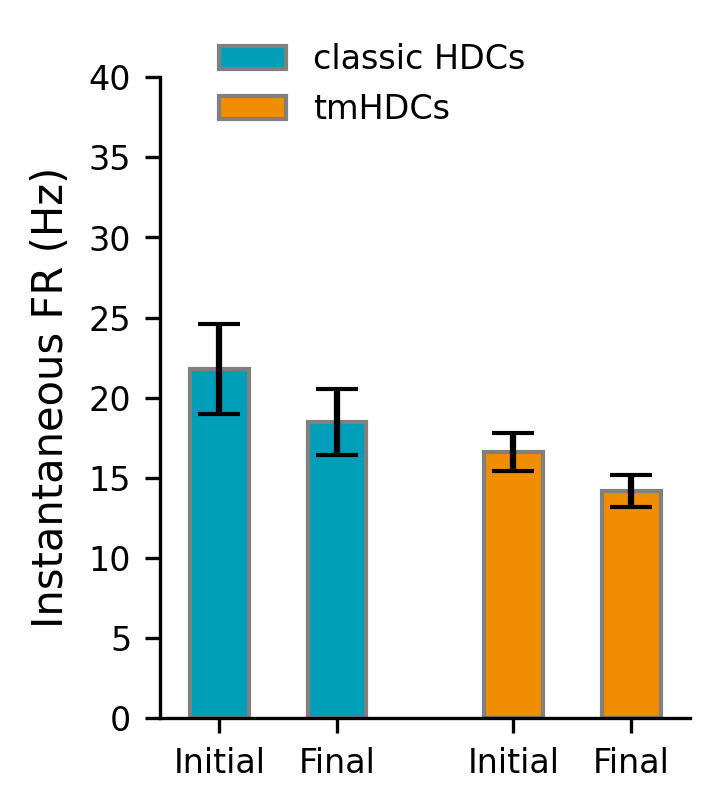

In [8]:

#plot a bar plot with cHD_init, cHD_final as a group 1 & 2, pHD_init and pHD_final as a group 3&4
#add error bars to each group

fig, ax = plt.subplots(figsize=(2.5, 2.8), dpi=300)
labelsize = 10
ticksize = 8
barWidth = 0.5

mean_cHD_init = np.mean(cHD_init)
std_cHD_init = np.std(cHD_init)/np.sqrt(len(cHD_init))

mean_cHD_final = np.mean(cHD_final)
std_cHD_final = np.std(cHD_final)/np.sqrt(len(cHD_final))

mean_pHD_init = np.mean(pHD_init)
std_pHD_init = np.std(pHD_init)/np.sqrt(len(pHD_init))

mean_pHD_final = np.mean(pHD_final)
std_pHD_final = np.std(pHD_final)/np.sqrt(len(pHD_final))

bars1 = [mean_cHD_init, mean_cHD_final, mean_pHD_init, mean_pHD_final]
errors1 = [std_cHD_init, std_cHD_final, std_pHD_init, std_pHD_final]

r1 = np.asarray([1,2,3.5,4.5])

ax.bar(r1[0:2], bars1[0:2], yerr=errors1[0:2], color=['#009FB9', '#009FB9'], width=barWidth, edgecolor='grey', capsize=5, label='classic HDCs')
ax.bar(r1[2:4], bars1[2:4], yerr=errors1[2:4], color=['#F18D00', '#F18D00'], width=barWidth, edgecolor='grey', capsize=5, label='tmHDCs')


ax.set_xticks([r for r in r1])
ax.set_xticklabels(['Initial', 'Final', 'Initial', 'Final'], fontsize=ticksize)
ax.set_ylabel('Instantaneous FR (Hz)', fontsize=labelsize)
ax.set_xlim(0.5, 5)
ax.legend(bbox_to_anchor=(0.4, 1.1), loc='upper center', frameon=False, fontsize=ticksize, ncol=1)
# ax.set_title('Firing Rate Adaptation')
ax.set_ylim(0, 40)
# ax.set_yticks([70, 80, 90])
ax.tick_params(axis='both', labelsize=ticksize)

sns.despine()

plt.tight_layout()

#perform wilcoxon sign rank test
from scipy.stats import wilcoxon
stat, p = wilcoxon(cHD_init, cHD_final)
print('Statistics=%.3f, p=%.3f' % (stat, p))

stat, p = wilcoxon(pHD_init, pHD_final)
print('Statistics=%.3f, p=%.3f' % (stat, p))

cHD_diff = [cHD_init[i] - cHD_final[i] for i in range(len(cHD_init))]
pHD_diff = [pHD_init[i] - pHD_final[i] for i in range(len(pHD_init))]


print(np.mean(cHD_diff), np.std(cHD_diff))
print(np.mean(pHD_diff), np.std(pHD_diff))
#perform t test for the difference
from scipy.stats import ttest_ind
stat, p = ttest_ind(cHD_diff, pHD_diff)
print('Statistics=%.3f, p=%.3f' % (stat, p))

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/FiringRateAdaptation.pdf', dpi=300)

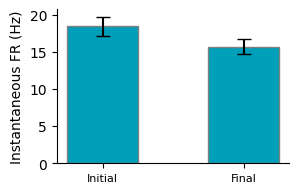

In [9]:

#merge cHD_init and pHD_init in initial_instfr_avn
#merge cHD_final and pHD_final in final_instfr_avn
initial_instfr_avn = np.concatenate((cHD_init, pHD_init))
final_instfr_avn = np.concatenate((cHD_final, pHD_final))

fig, ax = plt.subplots(figsize=(3,2))
labelsize = 10
ticksize = 8
barWidth = 0.5

mean_initial_instfr_avn = np.mean(initial_instfr_avn)
std_initial_instfr_avn = np.std(initial_instfr_avn)/np.sqrt(len(initial_instfr_avn))

mean_final_instfr_avn = np.mean(final_instfr_avn)
std_final_instfr_avn = np.std(final_instfr_avn)/np.sqrt(len(final_instfr_avn))

bars1 = [mean_initial_instfr_avn, mean_final_instfr_avn]
errors1 = [std_initial_instfr_avn, std_final_instfr_avn]

r1 = np.asarray([1,2])

ax.bar(r1[0:2], bars1[0:2], yerr=errors1[0:2], color=['#009FB9', '#009FB9'], width=barWidth, edgecolor='grey', capsize=5, label='Initial vs Final')

ax.set_xticks([r for r in r1])
ax.set_xticklabels(['Initial', 'Final'], fontsize=ticksize)
ax.set_ylabel('Instantaneous FR (Hz)', fontsize=labelsize)

# ax.set_title('Firing Rate Adaptation')
sns.despine()

#save initial_instfr_avn and final_instfr_avn as an npz file
np.savez('/home/zilong/Desktop/HDPhasePrecession/figures/avn_initfinal_fr.npz', initial_instfr_avn=initial_instfr_avn, final_instfr_avn=final_instfr_avn)

In [10]:
print(len(initial_instfr_avn), len(final_instfr_avn))

190 190
